In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0
)

In [3]:
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BtvaiGgvA1AZcTWzkcifmc4zUkx0O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--34f1266a-ebeb-4b3b-88d2-9d78db7faa13-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from langchain_core.tools import tool
from datetime import datetime, timedelta
from typing import Optional
import requests
import math

In [5]:
def get_geocode_locationiq(place):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": os.getenv("GEOLOCATION_IQ_API_KEY"),  
        "q": place,
        "format": "json"
    }
    res = requests.get(url, params=params)
    data = res.json()
    # print(data)
    # print('\n')
    if data:
        return float(data[0]["lat"]), float(data[0]["lon"])
    else:
        return None

In [6]:
@tool
def geocode_locationiq(place: str) -> dict:
    """
    Geocode a human-readable place name into geographic coordinates using LocationIQ API.

    This tool takes a location name (e.g., "Park Street, Kolkata" or "USF, Tampa") 
    and returns geospatial metadata including its bounding box, latitude, longitude, 
    display name, and location type.

    Parameters:
        place (str): The name of the location to geocode.

    Returns:
        dict: A dictionary containing the following keys:
            - 'boundingbox': List of [min_lat, max_lat, min_lng, max_lng]
            - 'lat': Latitude of the place (float)
            - 'lon': Longitude of the place (float)
            - 'display_name': Full formatted address (str)
            - 'type': Type of place (e.g., 'university', 'neighbourhood')
            
        If geocoding fails, a dictionary with an 'error' key is returned.
    """
    
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": os.getenv("GEOLOCATION_IQ_API_KEY"),
        "q": place,
        "format": "json"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if not data:
            return {"error": f"No result found for place: {place}"}

        first_result = data[0]
        return {
            "boundingbox": first_result.get("boundingbox"),
            "lat": float(first_result.get("lat")),
            "lon": float(first_result.get("lon")),
            "display_name": first_result.get("display_name"),
            "type": first_result.get("type")
        }

    except Exception as e:
        return {"error": str(e)}


@tool
def get_places(city: str, query: str = "attractions") -> list:
    """
    Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API
    and returns them as a structured JSON list.

    Parameters:
        city (str): Name of the city (e.g., 'Kolkata')
        query (str): Type of places to search for (e.g., 'attractions', 'museums')

    Returns:
        list: A list of dictionaries, each containing:
            - name: Place name
            - categories: List of category names
            - address: Formatted address
            - phone: Telephone number if available
            - website: Website URL if available
"""
    api_key = os.getenv("FOURSQUARE_API_KEY")
    if not api_key:
        return [{"error": "Missing FOURSQUARE_API_KEY"}]

    url = "https://places-api.foursquare.com/places/search"
    headers = {
        "accept": "application/json",
        "X-Places-Api-Version": "2025-06-17",
        "authorization": api_key
    }
    params = {
        "near": city,
        "query": query,
        "limit": 10
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        return [{"error": f"Foursquare API error: {response.text}"}]

    results = response.json().get("results", [])
    if not results:
        return [{"message": f"No results found for '{query}' in {city}."}]

    extracted = []
    for place in results:
        name = place.get("name", "Unknown")
        categories = [cat.get("name") for cat in place.get("categories", [])]
        
        address = place['location']['formatted_address']
        lat, lon = get_geocode_locationiq(address)
        
        phone = place.get("tel", None)
        website = place.get("website", None)

        extracted.append({
            "name": name,
            "categories": categories,
            "address": address,
            "latitude": lat,
            "longitude": lon,
            "phone": phone,
            "website": website
        })

    return extracted


def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points on Earth."""
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)
    a = math.sin(d_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

@tool
def get_hotels_by_area_and_radius(
    bbox: str,
    arrival_date: Optional[str] = None,
    departure_date: Optional[str] = None,
    star_rating: str = "3,4,5",
    room_qty: int = 1,
    guest_qty: int = 1,
    children_qty: int = 0,
    children_age: str = "",
    currency: str = "USD",
    order_by: str = "popularity",
    categories_filter: str = "class::1,class::2,class::3",
    language: str = "en-us",
    travel_purpose: str = "leisure",
    offset: int = 0
) -> list:
    """
    Fetch hotel listings within a bounding box, sorted by distance to its center. If no dates are provided, use today's date as `arrival_date` and tomorrow's as `departure_date`.

    Parameters:
        - bbox (str): Bounding box in format "min_lat,max_lat,min_lng,max_lng"
        - star_rating (str): Comma-separated star classes to filter, e.g., "3,4,5"
        - arrival_date (str): Check-in date (YYYY-MM-DD)
        - departure_date (str): Check-out date (YYYY-MM-DD)
        - room_qty (int): Number of rooms
        - guest_qty (int): Number of adults
        - children_qty (int): Number of children
        - children_age (str): Comma-separated list of children ages
        - currency (str): Price currency (e.g., USD, INR)
        - order_by (str): API sort preference (not used post-filter)
        - categories_filter (str): Used internally, overridden by star_rating
        - language (str): Response language
        - travel_purpose (str): "leisure" or "business"
        - offset (int): Pagination offset

    Returns:
        - list of hotel dicts sorted by ascending distance from bbox center.
    """
    
    today = datetime.today()
    
    if not arrival_date:
        arrival_date = today.strftime("%Y-%m-%d")
        
    if not departure_date:
        departure_date = (today + timedelta(days=1)).strftime("%Y-%m-%d")

    # Convert star_rating to API-compatible format
    categories_filter = ",".join([f"class::{s.strip()}" for s in star_rating.split(",")])

    # Compute bbox center
    try:
        min_lat, max_lat, min_lng, max_lng = map(float, bbox.split(","))
        center_lat = (min_lat + max_lat) / 2
        center_lng = (min_lng + max_lng) / 2
    except Exception as e:
        return [{"error": f"Invalid bbox format: {e}"}]

    url = "https://apidojo-booking-v1.p.rapidapi.com/properties/list-by-map"
    
    querystring = {
        "room_qty": str(room_qty),
        "guest_qty": str(guest_qty),
        "bbox": bbox,
        "search_id": "none",
        "children_age": children_age,
        "price_filter_currencycode": currency,
        "categories_filter": categories_filter,
        "languagecode": language,
        "travel_purpose": travel_purpose,
        "children_qty": str(children_qty),
        "order_by": order_by,
        "offset": str(offset),
        "arrival_date": arrival_date,
        "departure_date": departure_date
    }
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_HOTELS"),
        "x-rapidapi-host": "apidojo-booking-v1.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code != 200:
        return [{"error": response.text}]

    results = response.json().get("result", [])
    hotels = []

    for item in results:
        if not item.get("class"):
            continue

        lat = item.get("latitude")
        lng = item.get("longitude")
        if lat is None or lng is None:
            continue

        distance_km = haversine_distance(center_lat, center_lng, lat, lng)

        hotels.append({
            "name": item.get("hotel_name"),
            "star_rating": item.get("class"),
            "review_score": item.get("review_score"),
            "review_word": item.get("review_score_word"),
            "review_count": item.get("review_nr"),
            "address": item.get("address"),
            "city": item.get("city"),
            "district": item.get("district"),
            "latitude": lat,
            "longitude": lng,
            "price_per_night": item.get("min_total_price") or (
                item.get("price_breakdown", {}).get("all_inclusive_price")
            ),
            "currency": item.get("currencycode", currency),
            "image": item.get("main_photo_url"),
            "booking_url": item.get("url"),
            "is_free_cancellable": item.get("is_free_cancellable"),
            "is_mobile_deal": item.get("is_mobile_deal"),
            "checkin_from": item.get("checkin", {}).get("from"),
            "checkout_until": item.get("checkout", {}).get("until"),
            "arrival_date": arrival_date,
            "departure_date": departure_date,
            "distance_km": round(distance_km, 2)
        })

    # Sort by distance from bbox center
    hotels.sort(key=lambda h: h["distance_km"])
    return hotels


@tool
def convert_currency(amount: float, to_currency: str, base: str = "USD") -> float:
    """
    Convert a monetary amount from one currency to another using real-time exchange rates.

    This function fetches the latest exchange rate between the specified base currency
    and the target currency using the ExchangeRate-API and calculates the converted value.

    Args:
        amount (float): The amount of money to convert.
        to_currency (str): The target currency code (e.g., "EUR", "INR").
        base (str, optional): The source currency code. Defaults to "USD".

    Returns:
        float: The converted amount in the target currency, rounded to two decimal places.
                If the exchange rate is unavailable, returns a dictionary with an error message.

    Example:
        >>> convert_currency(100, "INR")
        8356.25

    Notes:
        - This tool uses the open endpoint from https://open.er-api.com.
        - Ensure that `to_currency` and `base` are valid ISO currency codes.
    """
    url = f"https://open.er-api.com/v6/latest/{base}"
    resp = requests.get(url)
    data = resp.json()
    rate = data["rates"].get(to_currency)
    if not rate:
        return {"error": f"Rate unavailable for {to_currency}"}
    return round(amount * rate, 2)



@tool
def get_weather(city: str) -> dict:
    """Get detailed current weather data for a city as a dictionary."""
    
    api_key = os.getenv("OPENWEATHER_API_KEY")
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)
    
    if response.status_code != 200:
        return {"error": f"Failed to get weather: {response.text}"}
    
    data = response.json()
    lat, lon = get_geocode_locationiq(city)
    
    return {
        "city": data.get("name"),
        "country": data.get("sys", {}).get("country"),
        "description": data.get("weather", [{}])[0].get("description"),
        "temperature_celsius": data.get("main", {}).get("temp"),
        "feels_like_celsius": data.get("main", {}).get("feels_like"),
        "temp_min": data.get("main", {}).get("temp_min"),
        "temp_max": data.get("main", {}).get("temp_max"),
        "humidity": data.get("main", {}).get("humidity"),
        "pressure": data.get("main", {}).get("pressure"),
        "wind_speed_mps": data.get("wind", {}).get("speed"),
        "wind_deg": data.get("wind", {}).get("deg"),
        "visibility_m": data.get("visibility"),
        "cloud_coverage_percent": data.get("clouds", {}).get("all"),
        "sunrise_utc": data.get("sys", {}).get("sunrise"),
        "sunset_utc": data.get("sys", {}).get("sunset"),
        "icon": data.get("weather", [{}])[0].get("icon"),
        "latitude": lat,
        "longitude": lon,
        
    }

@tool
def get_flight_fares(from_code: str, to_code: str, date: str, adult: int = 1, type_: str = "economy") -> list:
    """
    Fetches flight fare data using the Flight Fare Search API on RapidAPI.

    Args:
        from_code (str): IATA code of departure airport (e.g., 'BLR')
        to_code (str): IATA code of arrival airport (e.g., 'CCU')
        date (str): Travel date in YYYY-MM-DD
        adult (int): Number of adult passengers (default: 1)
        type_ (str): Cabin class (default: 'economy')

    Returns:
        list: List of flights with key details: timing, pricing, stops, countries, and cabin info.
    """
    
    url = "https://flight-fare-search.p.rapidapi.com/v2/flights"

    querystring = {
        "from": from_code,
        "to": to_code,
        "date": date,
        "adult": str(adult),
        "type": type_,
        "currency": "USD"
    }

    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_FLIGHTS"),
        "x-rapidapi-host": "flight-fare-search.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    # print("🔍 Raw API response:", response.status_code, response.text)

    try:
        raw = response.json()
        flights = raw.get("results", [])
        if not isinstance(flights, list) or not flights:
            return [{"message": "No flights found."}]

        results = []
        for f in flights:
            stop_info = []
            stop_summary = f.get("stopSummary", {})

            # Extract intermediate stops if present
            if isinstance(stop_summary, dict):
                for key, val in stop_summary.items():
                    if key != "connectingTime" and isinstance(val, dict):
                        stop_info.append({
                            "intermediate_airport": val.get("airport", "Unknown"),
                            "stop_duration_minutes": val.get("stopDuration")
                        })

            results.append({
                "flight_code": f.get("flight_code"),
                "airline": f.get("flight_name"),
                "cabin_type": f.get("cabinType", "Unknown"),
                "stops": f.get("stops", "Unknown"),
                "departure_city": f.get("departureAirport", {}).get("city"),
                "departure_country": f.get("departureAirport", {}).get("country", {}).get("label"),
                "departure_time": f.get("departureAirport", {}).get("time"),
                "arrival_city": f.get("arrivalAirport", {}).get("city"),
                "arrival_country": f.get("arrivalAirport", {}).get("country", {}).get("label"),
                "arrival_time": f.get("arrivalAirport", {}).get("time"),
                "duration": f.get("duration", {}).get("text"),
                "price": f.get("totals", {}).get("total"),
                "currency": f.get("totals", {}).get("currency"),
                "intermediate_stops": stop_info if stop_info else None
            })

        return results

    except Exception as e:
        return [{"error": str(e)}]

In [7]:
response = get_hotels_by_area_and_radius.invoke({
    "bbox": "12.8300,12.9500,77.5000,77.6500", ## South Bangalore
    "star_rating": "4,5"
})
response

[{'name': 'Collection O Bannergatta Road Near Decathlon',
  'star_rating': 4.0,
  'review_score': 7.8,
  'review_word': 'Good',
  'review_count': 63,
  'address': 'Himagiri, Gottigere, Near Decathlon, Bannerghatta Road',
  'city': 'Bangalore',
  'district': '',
  'latitude': 12.8614167,
  'longitude': 77.58975,
  'price_per_night': 919.64,
  'currency': 'INR',
  'image': 'https://cf.bstatic.com/xdata/images/hotel/square60/663567041.jpg?k=ab89b7dea9be23e85272ab67695b87ae436646fee9c44720c2acd8bab4e41907&o=',
  'booking_url': 'https://www.booking.com/hotel/in/collection-o-82501-blue-waters-lounge-bangalore.html',
  'is_free_cancellable': 1,
  'is_mobile_deal': 0,
  'checkin_from': '12:00',
  'checkout_until': '11:00',
  'arrival_date': '2025-07-16',
  'departure_date': '2025-07-17',
  'distance_km': 3.56},
 {'name': 'Super Townhouse BTM Layout Near Madiwala Lake Formerly Q Rooms',
  'star_rating': 4.0,
  'review_score': 7.6,
  'review_word': 'Good',
  'review_count': 189,
  'address': 'Pl

In [8]:
# response = get_hotels_by_area_and_radius.invoke({
#     "bbox": "12.8300,12.9500,77.5000,77.6500", ## South Bangalore
#     "arrival_date": "2025-07-17",
#     "departure_date": "2025-07-19",
#     "star_rating": "4,5"
# })
# response

In [9]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch()

# search_tool.invoke("what's going on in paris?")

In [10]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, StateGraph, START, END

In [11]:
class Router(TypedDict):
    next: Literal["hotel_search_expert", "weather_expert", "place_search_expert", "flight_fares_search_expert", "geolocation_expert", 'FINISH']

class State(MessagesState):
    next:str

In [12]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

In [13]:
def supervisor(state: State) -> Command[Literal["hotel_search_expert", "weather_expert", "place_search_expert", "flight_fares_search_expert", "geolocation_expert", "__end__"]]:
    """
    The supervisor routes tasks to the appropriate expert based on the user message context.
    It uses an LLM with structured output to decide which agent to call next.
    """
    
    system_prompt = f"""
    You are a Supervisor Agent coordinating a travel assistant system with the following expert agents:
    {', '.join([
        'hotel_search_expert',
        'weather_expert',
        'place_search_expert',
        'flight_fares_search_expert',
        'geolocation_expert'
    ])}

    Each agent performs a specific task:
    - hotel_search_expert: Finds real-time hotels using a bounding box, travel dates, and optional filters (e.g., star rating)
    - weather_expert: Returns current weather for a given city
    - place_search_expert: Suggests attractions, restaurants, and cultural spots near a location
    - flight_fares_search_expert: Finds flights and fares between two IATA codes on a specific date
    - geolocation_expert: Converts place names into latitude, longitude, and bounding boxes (~5km radius)

    Your role:
    - Read the latest user query and conversation context
    - Decide which agent to invoke next
    - Handle dependencies (e.g., get bbox before hotel search)
    - Reply FINISH only after the user's request is fully satisfied

    Always include `latitude` and `longitude` for any place-related query (e.g., city, hotel, restaurant, attraction) in the final output — either in the main content or structured HTML.

    Response format:
    Return ONLY one of the following at a time:
    - The name of the agent to call next (e.g., hotel_search_expert)
    - A short explanation of why that agent is needed
    - Input hints or parameters for the agent
    - The word FINISH if all steps are complete

    Decision rules:
    - If the query involves hotels, stays, accommodation, or star ratings (e.g., 3-star, 4-star):
    - First call geolocation_expert to get a bounding box
    - Then call hotel_search_expert to find listings using the bbox and available dates
    - Do NOT stop after geolocation — hotel search must follow

    - For flight searches between cities with a date, directly call flight_fares_search_expert (do not call geolocation)

    - Always decompose multi-part goals (e.g., hotels + weather + flights) into sequential steps

    - Do NOT hallucinate inputs or output — only use what is extracted or known
    - Never assign tasks outside an expert’s scope

    Once the user's goal is complete and no other agent needs to be invoked, return FINISH.

    User Request:
    """
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    llm_with_structure_output = llm.with_structured_output(Router)
    response = llm_with_structure_output.invoke(messages)

    goto = response["next"]

    if goto == "FINISH":
        return Command(goto=END)
    else:
        return Command(goto=goto, update={"next": goto})

In [14]:
def hotel_search_agent(state: State) -> Command[Literal["supervisor"]]:
    """
    The hotel expert uses the hotel-related tools to find hotels based on location, star rating, and dates.
    """
    agent = create_react_agent(
        llm,
        tools=[get_hotels_by_area_and_radius, geocode_locationiq],
        prompt="""
            You are a hotel search expert. Geocode the location first if bbox is missing. 
            Then use the hotel search tool to find top results. For each hotel, return the following fields in HTML format:

            - name
            - star_rating
            - review_score
            - review_word
            - review_count
            - address
            - city
            - district
            - latitude
            - longitude
            - price_per_night
            - currency
            - image
            - booking_url
            - is_free_cancellable
            - is_mobile_deal
            - checkin_from
            - checkout_until
            - arrival_date
            - departure_date
            - distance_km
            
            `latitude` and `longitude` must always be included.
            Do not return bbox, display_name, or type in the final output. Just output a clean HTML <ul> list showing all above fields.
        """


    )

    result = agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="hotel_search_expert")
            ]
        },
        goto="supervisor",
    )


def weather_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[get_weather],
        prompt="""
            You are a weather expert. Use the weather tool to fetch real-time weather for the user's city.

            Return the result in clean HTML format using <ul>/<li> or <div>. Include:

            - City and Country
            - Description (e.g., clear sky, light rain)
            - Temperature (actual, feels like, min, max)
            - Humidity, Pressure
            - Wind speed and direction
            - Visibility (in meters), Cloud Coverage (%)
            - Sunrise and Sunset in UTC
            - Latitude and Longitude (always include)
            - Optional: weather icon <img> if available
            
            `latitude` and `longitude` must always be included.
            Do not use JSON or plain text. Only output valid, well-structured HTML.
        """


    )

    result = agent.invoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="weather_expert")]},
        goto="supervisor"
    )


def place_search_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[get_places],
        prompt="""
            You are an expert in finding attractions, restaurants, and cultural places.

            Use the get_places tool to return the top 5 places.

            For each result, include:
            - Name
            - Category (e.g., museum, restaurant)
            - Address
            - Latitude and Longitude (always include)
            - Phone (if available)
            - Website (as a clickable link)
            
            `latitude` and `longitude` must always be included.
            Return the output in clean HTML format using <ul>/<li> or <div>. No JSON or plain text. Keep it structured and readable.
        """


    )

    result = agent.invoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="place_search_expert")]},
        goto="supervisor"
    )


def flight_fares_search_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[get_flight_fares],
        prompt="""
            You are a flight search expert. Use the flight API to return flight fares and details.

            For each result, include:
            - From and To airport codes
            - Departure and Arrival time
            - Airline and number of Stops
            - Fare with currency

            Respond in HTML format using <ul>/<li> or <div>. Avoid JSON or plain text.
            """


    )

    result = agent.invoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="flight_fares_search_expert")]},
        goto="supervisor"
    )

def geolocation_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[geocode_locationiq],
        prompt="""
            You are a geolocation expert. Convert place names into coordinates and bounding boxes.

            Always include:
            - Display Name
            - Latitude and Longitude
            - Bounding Box (min_lat, max_lat, min_lon, max_lon)
            - Type (e.g., city, hotel, attraction)
            
            `latitude` and `longitude` must always be included.
            Respond using HTML format with <ul>/<li> or <div>. Do not use JSON or plain text.
        """


    )

    result = agent.invoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="geolocation_expert")]},
        goto="supervisor"
    )

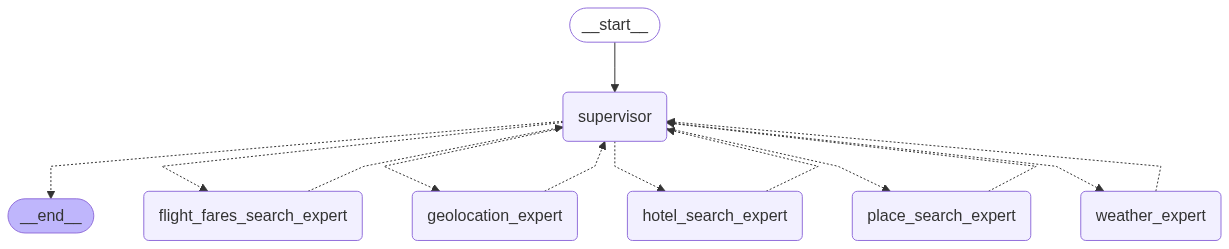

In [15]:
# Define the graph
graph = StateGraph(State)

# Add nodes
graph.add_node("supervisor", supervisor)
graph.add_node("hotel_search_expert", hotel_search_agent)
graph.add_node("weather_expert", weather_agent)
graph.add_node("place_search_expert", place_search_agent)
graph.add_node("flight_fares_search_expert", flight_fares_search_agent)
graph.add_node("geolocation_expert", geolocation_agent)

# Initial entry point
graph.add_edge(START, "supervisor")

# Return control to supervisor after each expert agent runs
graph.add_edge("hotel_search_expert", "supervisor")
graph.add_edge("weather_expert", "supervisor")
graph.add_edge("place_search_expert", "supervisor")
graph.add_edge("flight_fares_search_expert", "supervisor")
graph.add_edge("geolocation_expert", "supervisor")

# ✅ Add this missing edge so that "FINISH" works correctly
graph.add_edge("supervisor", "__end__")

# Compile the app
app = graph.compile()
app

In [16]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user",
                        """
                        I’m planning a short leisure trip to South Goa next weekend. Please suggest some 3-star or 4-star hotels in that area with 
                        free cancellation options if available. I’ll be traveling as an adult, with check-in on July 18, 2025, and check-out on July 21, 2025.
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        I’m planning a short leisure trip to South Goa next weekend. Please suggest some 3-star or 4-star hotels in that area with 
                        free cancellation options if available. I’ll be traveling as an adult, with check-in on July 18, 2025, and check-out on July 21, 2025.
                        
================================ Human Message =================================


                        I’m planning a short leisure trip to South Goa next weekend. Please suggest some 3-star or 4-star hotels in that area with 
                        free cancellation options if available. I’ll be traveling as an adult, with check-in on July 18, 2025, and check-out on July 21, 2025.
                        
================================ Human Message =================================
Name: geolocation_expert

I can help you with the geolo

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


In [17]:
print(res[-1])

```html
<ul>
    <li>
        <strong>Name:</strong> Super Townhouse Madgaon<br>
        <strong>Star Rating:</strong> 4.0<br>
        <strong>Review Score:</strong> 5.7<br>
        <strong>Review Word:</strong> Okay<br>
        <strong>Review Count:</strong> 71<br>
        <strong>Address:</strong> Near Bolshe Circle, Near Max Mall, Gogol, Near Madgaon Railway Station<br>
        <strong>City:</strong> Goa<br>
        <strong>District:</strong> <br>
        <strong>Latitude:</strong> 15.284639<br>
        <strong>Longitude:</strong> 73.979639<br>
        <strong>Price per Night:</strong> 3967.79<br>
        <strong>Currency:</strong> INR<br>
        <strong>Image:</strong> <img src="https://cf.bstatic.com/xdata/images/hotel/square60/640220881.jpg?k=c4ae9db79d7d65b4e6fbc7ac8d4131d9bb8e7de479723b5f84aee452336e0b56&o=" alt="Super Townhouse Madgaon"><br>
        <strong>Booking URL:</strong> <a href="https://www.booking.com/hotel/in/pop-82473g-golden-vista.html">Book Here</a><br>
        

In [18]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user","""
                        suggest some trekking places near chennai
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        suggest some trekking places near chennai
                        
================================ Human Message =================================


                        suggest some trekking places near chennai
                        
================================ Human Message =================================
Name: geolocation_expert

<div>
    <h2>Trekking Places Near Chennai</h2>
    <ul>
        <li>
            <strong>Display Name:</strong> Yelagiri, Tirupathur, Tamil Nadu, India<br>
            <strong>Latitude:</strong> 12.589316<br>
            <strong>Longitude:</strong> 78.6323577<br>
            <strong>Bounding Box:</strong> (min_lat: 12.549316, max_lat: 12.629316, min_lon: 78.5923577, max_lon: 78.6723577)<br>
            <strong>Type:</strong> Town
        </li>
        <li>
            <strong>Display Name:</strong> Kudrem

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


In [19]:
print(res[-1])

<div>
    <h2>Trekking Places Near Chennai</h2>
    <ul>
        <li>
            <strong>Name:</strong> Yelagiri<br>
            <strong>Category:</strong> Town<br>
            <strong>Address:</strong> Tirupathur, Tamil Nadu, India<br>
            <strong>Latitude:</strong> 12.589316<br>
            <strong>Longitude:</strong> 78.6323577<br>
        </li>
        <li>
            <strong>Name:</strong> Kudremukha<br>
            <strong>Category:</strong> Village<br>
            <strong>Address:</strong> Kalasa taluk, Chikkamagaluru, Karnataka, India<br>
            <strong>Latitude:</strong> 13.2190695<br>
            <strong>Longitude:</strong> 75.2510322<br>
        </li>
        <li>
            <strong>Name:</strong> Nandi Hills State Forest<br>
            <strong>Category:</strong> Wood<br>
            <strong>Address:</strong> Kanivenarayanapura, Chikkaballapura taluk, Chikkaballapura, Karnataka, India<br>
            <strong>Latitude:</strong> 13.5221981<br>
            <str

In [20]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user","""
                        how is the weather in kolkata today?
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        how is the weather in kolkata today?
                        
================================ Human Message =================================


                        how is the weather in kolkata today?
                        
================================ Human Message =================================
Name: weather_expert

<div>
    <h2>Weather in Kolkata, India</h2>
    <ul>
        <li><strong>Description:</strong> Overcast clouds</li>
        <li><strong>Temperature:</strong>
            <ul>
                <li>Actual: 31.29°C</li>
                <li>Feels Like: 37.15°C</li>
                <li>Min: 31.29°C</li>
                <li>Max: 31.29°C</li>
            </ul>
        </li>
        <li><strong>Humidity:</strong> 66%</li>
        <li><strong>Pressure:</strong> 1001 hPa</li>
        <li><strong>Wind:</strong>
            <ul>
  

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


In [21]:
print(res[-1])

<div>
    <h2>Weather in Kolkata, India</h2>
    <ul>
        <li><strong>Description:</strong> Overcast clouds</li>
        <li><strong>Temperature:</strong>
            <ul>
                <li>Actual: 31.29°C</li>
                <li>Feels Like: 37.15°C</li>
                <li>Min: 31.29°C</li>
                <li>Max: 31.29°C</li>
            </ul>
        </li>
        <li><strong>Humidity:</strong> 66%</li>
        <li><strong>Pressure:</strong> 1001 hPa</li>
        <li><strong>Wind:</strong>
            <ul>
                <li>Speed: 4.95 m/s</li>
                <li>Direction: 181°</li>
            </ul>
        </li>
        <li><strong>Visibility:</strong> 10,000 meters</li>
        <li><strong>Cloud Coverage:</strong> 100%</li>
        <li><strong>Sunrise (UTC):</strong> 2023-12-12 05:30:59</li>
        <li><strong>Sunset (UTC):</strong> 2023-12-12 11:53:43</li>
        <li><strong>Latitude:</strong> 22.5726459</li>
        <li><strong>Longitude:</strong> 88.3638953</li>


In [22]:
# get_weather.invoke('kolkata')

In [23]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user","""
                        list all the flights available from bangalore to kolkata on July 17, 2025.
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        list all the flights available from bangalore to kolkata on July 17, 2025.
                        
================================ Human Message =================================


                        list all the flights available from bangalore to kolkata on July 17, 2025.
                        
================================ Human Message =================================
Name: flight_fares_search_expert

```html
<div>
    <h2>Available Flights from Bangalore (BLR) to Kolkata (CCU) on July 17, 2025</h2>
    <ul>
        <li>
            <strong>Flight Code:</strong> IX-1970<br>
            <strong>Airline:</strong> Air India Express<br>
            <strong>Departure:</strong> 04:45<br>
            <strong>Arrival:</strong> 19:30<br>
            <strong>Stops:</strong> 1 Stop<br>
            <strong>Fare:</strong> 69.89 USD
        </l

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


In [24]:
print(res[-1])

```html
<div>
    <h2>Available Flights from Bangalore (BLR) to Kolkata (CCU) on July 17, 2025</h2>
    <ul>
        <li>
            <strong>Flight Code:</strong> IX-1970<br>
            <strong>Airline:</strong> Air India Express<br>
            <strong>Departure:</strong> 04:45<br>
            <strong>Arrival:</strong> 19:30<br>
            <strong>Stops:</strong> 1 Stop<br>
            <strong>Fare:</strong> 69.89 USD
        </li>
        <li>
            <strong>Flight Code:</strong> IX-1574<br>
            <strong>Airline:</strong> Air India Express<br>
            <strong>Departure:</strong> 14:30<br>
            <strong>Arrival:</strong> 17:20<br>
            <strong>Stops:</strong> Direct<br>
            <strong>Fare:</strong> 69.14 USD
        </li>
        <li>
            <strong>Flight Code:</strong> IX-2718<br>
            <strong>Airline:</strong> Air India Express<br>
            <strong>Departure:</strong> 19:05<br>
            <strong>Arrival:</strong> 21:50<br>
    

In [25]:
# print(res[-2])

In [26]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user","""
                        List some 3 & 4 star hotels in south Kolkata. User ratings 4 star or above. 
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        List some 3 & 4 star hotels in south Kolkata. User ratings 4 star or above. 
                        
================================ Human Message =================================


                        List some 3 & 4 star hotels in south Kolkata. User ratings 4 star or above. 
                        
================================ Human Message =================================
Name: geolocation_expert

<div>
    <h2>3 & 4 Star Hotels in South Kolkata (User Ratings 4 Star or Above)</h2>
    <ul>
        <li>
            <strong>Hotel Hindusthan International</strong>
            <ul>
                <li>Display Name: Hotel Hindusthan International</li>
                <li>Latitude: 22.5645</li>
                <li>Longitude: 88.3665</li>
                <li>Bounding Box: (22.5600, 22.5700, 88.3600, 88.3700)</li>
                <li>Type

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


In [27]:
print(res[-1])

```html
<ul>
    <li>
        <strong>Hotel Hindusthan International</strong>
        <ul>
            <li>star_rating: 4</li>
            <li>review_score: 4.2</li>
            <li>review_word: Excellent</li>
            <li>review_count: 150</li>
            <li>address: 235/1, A.J.C. Bose Road</li>
            <li>city: Kolkata</li>
            <li>district: Kolkata</li>
            <li>latitude: 22.5645</li>
            <li>longitude: 88.3665</li>
            <li>price_per_night: 5000</li>
            <li>currency: INR</li>
            <li>image: <img src="image_url_here" alt="Hotel Hindusthan International"></li>
            <li>booking_url: <a href="booking_url_here">Book Now</a></li>
            <li>is_free_cancellable: Yes</li>
            <li>is_mobile_deal: No</li>
            <li>checkin_from: 14:00</li>
            <li>checkout_until: 12:00</li>
            <li>arrival_date: 2023-10-05</li>
            <li>departure_date: 2023-10-06</li>
            <li>distance_km: 0.5</li

In [28]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user","""
                        Please suggest some available hotels near University of South Florida (USF), Tampa, Florida for 1 adult. 
                        I plan to stay for one night, with check-in on July 17, 2025, and check-out on July 18, 2025. 
                        Prioritize hotels within short distance to the university
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        Please suggest some available hotels near University of South Florida (USF), Tampa, Florida for 1 adult. 
                        I plan to stay for one night, with check-in on July 17, 2025, and check-out on July 18, 2025. 
                        Prioritize hotels within short distance to the university
                        
================================ Human Message =================================


                        Please suggest some available hotels near University of South Florida (USF), Tampa, Florida for 1 adult. 
                        I plan to stay for one night, with check-in on July 17, 2025, and check-out on July 18, 2025. 
                        Prioritize hotels within short distance to the university
                        
================================ Human Message =================================
Name: g

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


In [29]:
print(res[-1])

```html
<ul>
    <li>
        <strong>name:</strong> Hampton Inn & Suites Tampa - North<br>
        <strong>star_rating:</strong> 3<br>
        <strong>review_score:</strong> 8.5<br>
        <strong>review_word:</strong> Very Good<br>
        <strong>review_count:</strong> 250<br>
        <strong>address:</strong> 8210 Hidden River Pkwy<br>
        <strong>city:</strong> Tampa<br>
        <strong>district:</strong> Hillsborough County<br>
        <strong>latitude:</strong> 28.07000755<br>
        <strong>longitude:</strong> -82.36595305<br>
        <strong>price_per_night:</strong> 120<br>
        <strong>currency:</strong> USD<br>
        <strong>image:</strong> <img src="https://example.com/image1.jpg" alt="Hampton Inn & Suites Tampa - North"><br>
        <strong>booking_url:</strong> <a href="https://example.com/booking1">Book Now</a><br>
        <strong>is_free_cancellable:</strong> Yes<br>
        <strong>is_mobile_deal:</strong> No<br>
        <strong>checkin_from:</strong> 15:00

In [30]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user",
                        """
                        hi, how are you?
                        """)]
    },
    stream_mode="values"
)

res = []
for event in events:
    event["messages"][-1].pretty_print()
    content = event["messages"][-1].content
    
    if content:
        res.append(content)

Testing the multi-agent system...
================================ Human Message =================================


                        hi, how are you?
                        


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.
